In [1]:
import pylab
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

import time
import pickle
import bz2
import sys

sys.path.insert(1, '../')
import biosig
from data_extract_utils import *

In [2]:
start = time.time()
t1 = start
HDR = biosig.sopen('/home/sweet/1-workdir/eeg001-2017/S01_ME/motorexecution_subject1_run1.gdf','r')
print("Read header in %f s\n" % (time.time()-t1))

t1 = time.time()
data = biosig.sread(HDR, HDR.NRec, 0)
print("Read data in %f s\n" % (time.time()-t1))

biosig.sclose(HDR)


Read header in 0.007534 s

Read data in 35.206688 s



0

In [3]:
# map event type to event label
# class 1: 0x600 = 1536 (elbow flexion)
# class 2: 0x601 = 1537 (elbow extension)
# class 3: 0x602 = 1538 (supination)
# class 4: 0x603 = 1539 (pronation)
# class 5: 0x604 = 1540 (hand close)
# class 6: 0x605 = 1541 (hand open)
# class 7: 0x606 = 1542 (rest)

# also, there are event types that signify start of trials, computer beep, cross on screen
# 0x300 = 768 (start of trial)
# 0x311 = 785 (beep)
# 0x312 = 786 (cross on screen)
# numbers that are OR-ed with 0x8000 signify end of event.
event_map = {
    1536: 1,
    1537: 2,
    1538: 3,
    1539: 4,
    1540: 5,
    1541: 6,
    1542: 7
}

seqs_v_class_map = {
    1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []
}

In [4]:
t1 = time.time()
event_hit = 0
start_frame = 0
end_frame = 0
for i in range(len(HDR.EVENT.TYP)):
    code = HDR.EVENT.TYP[i]
    if event_hit == 0 and code in event_map:
        event_hit = code
        start_frame = HDR.EVENT.POS[i]
    
    if code == event_hit + 32768:
        end_frame = HDR.EVENT.POS[i]
        seqs_v_class_map[event_map[event_hit]].append(
            data[start_frame:end_frame+1, 0:64]
        )
        event_hit = 0
        
print("Finished segregating data into classes in %f s\n" % (time.time()-t1))


Finished segregating data into classes in 0.001883 s



In [5]:
# compress segregated data into zip file
# t1 = time.time()
# i_str = pickle.dumps(seqs_v_class_map)
# compressed_data = bz2.compress(i_str)
# f_size = sys.getsizeof(compressed_data)
# with bz2.open("compressed_data.bz2", "wb") as f:
#     f.write(compressed_data)
    
# print("Finished writing %f of data to file in %f s\n" % (f_size, time.time()-t1))

# finish = time.time()
# print("Done processing file in %f s\n" % (finish - start))

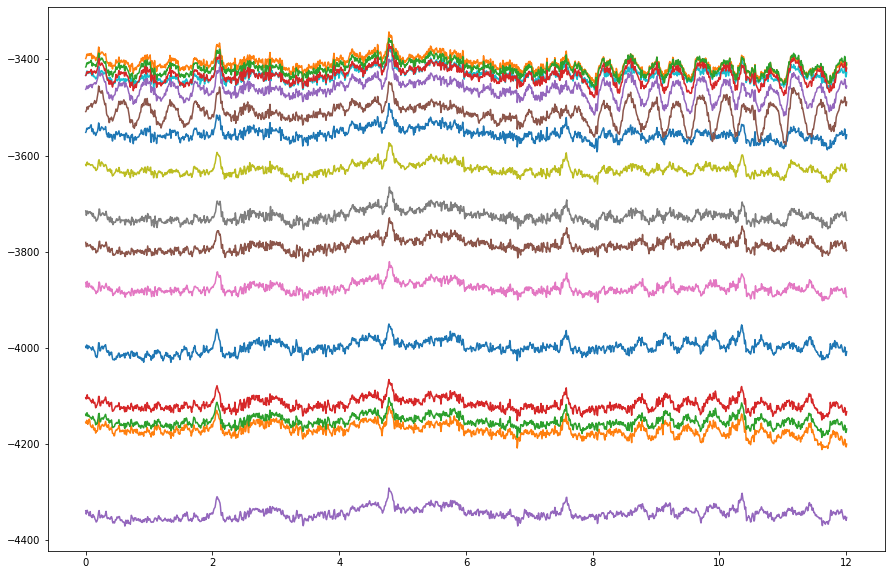

In [9]:
sig = seqs_v_class_map[7][2][:,0:61]
sig_downsampled = signal.decimate(sig, 4, 5, axis=1)
# sig_downsampled = (sig-np.min(sig, axis=0))/(np.max(sig, axis=0) - np.min(sig, axis=0))
t = np.linspace(0, len(sig)/128, len(sig))

f = plt.figure(figsize = (15,10))
f = plt.plot(t, sig_downsampled[:,0:61])

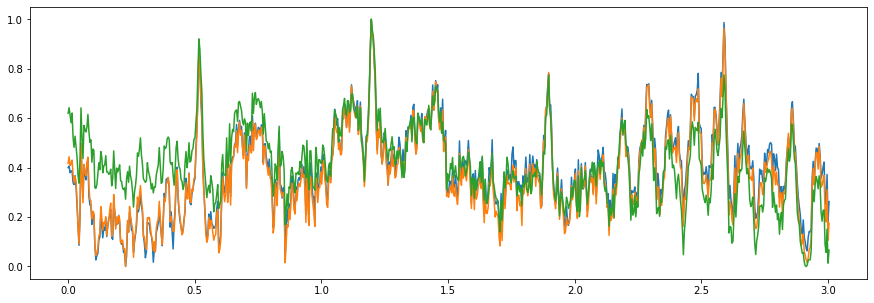

In [7]:
#biosig.destructHDR(HDR)

sig1 = seqs_v_class_map[7][2][:,0:61]
sig1 = signal.decimate(sig1, 2, 5, axis=0)
sig1 = (sig1-np.min(sig1, axis=0))/(np.max(sig1, axis=0) - np.min(sig1, axis=0))
t = np.linspace(0, len(sig1)/256, len(sig1))

f = plt.figure(figsize = (15,5))
f = plt.plot(t, sig1[:,0:3])

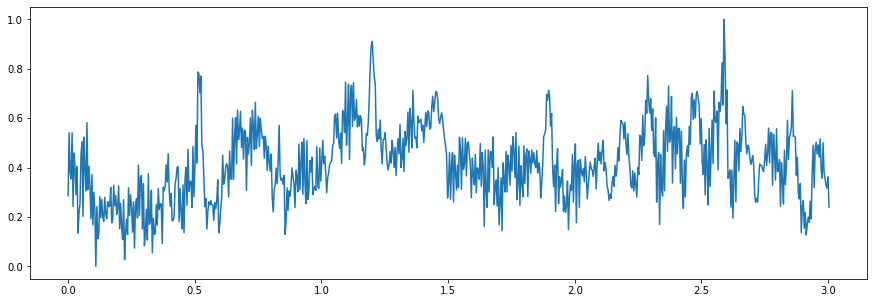

In [8]:
sig2 = seqs_v_class_map[7][2][:,0:61]
sig2 = signal.decimate(sig2, 2, 30, axis=0)
sig2 = (sig2-np.min(sig2, axis=0))/(np.max(sig2, axis=0) - np.min(sig2, axis=0))
t = np.linspace(0, len(sig2)/256, len(sig2))

f = plt.figure(figsize = (15,5))
f = plt.plot(t, sig2[:,0])

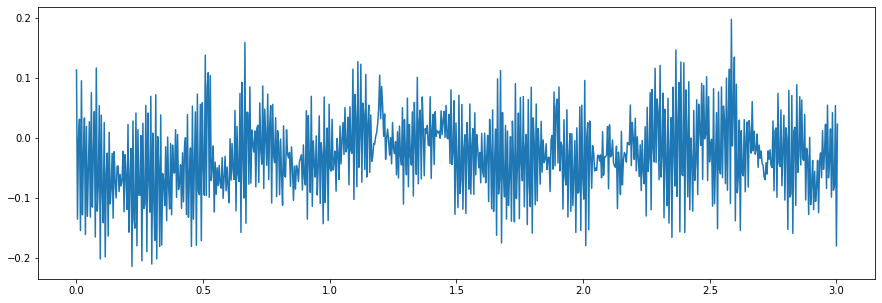

In [9]:
f = plt.figure(figsize = (15,5))
f = plt.plot(t, sig1[:,0] - sig2[:,0])

In [13]:
rejected_trials = reject_trials_from_map(seqs_v_class_map)

# rejected_trials_map = {}
# for key in seqs_v_class_map.keys():
#     rejected_trials_map[key] = np.zeros(len(seqs_v_class_map[key]), dtype='uint8')

# for l in rejected_trials:
#     rejected_trials_map[l[0]][l[1]] = 1

[[ 6  3 62]]


In [11]:
rejected_trials_map

{1: array([0, 0, 0, 0, 0, 0], dtype=uint8),
 2: array([0, 0, 0, 0, 0, 0], dtype=uint8),
 3: array([0, 0, 0, 0, 0, 1], dtype=uint8),
 4: array([0, 0, 0, 0, 0, 1], dtype=uint8),
 5: array([0, 0, 0, 0, 0, 1], dtype=uint8),
 6: array([0, 0, 0, 1, 0, 0], dtype=uint8),
 7: array([0, 0, 0, 0, 1, 0], dtype=uint8)}

In [12]:
# HDR.EVENT.TYP